# ANN-to-SNN conversion - MLP

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/ANN2SNN.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/ANN2SNN.ipynb)

This notebook demonstrates how to transform a fully-connected neural network trained using tensorflow/keras into an SNN network usable in ANNarchy.

The methods are adapted from the original models used in:

> Diehl et al. (2015) "Fast-classifying, high-accuracy spiking deep networks through weight and threshold balancing" Proceedings of IJCNN. doi: 10.1109/IJCNN.2015.7280696

In [1]:
#!pip install ANNarchy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(f"Tensorflow {tf.__version__}")

Tensorflow 2.16.1


First we need to download and process the MNIST dataset provided by tensorflow.

In [2]:
# Download data
(X_train, t_train), (X_test, t_test) = tf.keras.datasets.mnist.load_data()

# Normalize inputs
X_train = X_train.reshape(X_train.shape[0], 784).astype('float32') / 255.
X_test = X_test.reshape(X_test.shape[0], 784).astype('float32') / 255.

# One-hot output vectors
T_train = tf.keras.utils.to_categorical(t_train, 10)
T_test = tf.keras.utils.to_categorical(t_test, 10)

## Training an ANN in tensorflow/keras

The `tensorflow.keras` network is build using the functional API. 

The fully-connected network has two fully connected layers with ReLU, **no bias**, dropout at 0.5, and a softmax output layer with 10 neurons. We use the standard SGD optimizer and the categorical crossentropy loss for classification.

In [4]:
def create_mlp():
    # Model
    inputs = tf.keras.layers.Input(shape=(784,))
    x= tf.keras.layers.Dense(128, use_bias=False, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x= tf.keras.layers.Dense(128, use_bias=False, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(10, use_bias=False, activation='softmax')(x)

    model= tf.keras.Model(inputs, x)

    # Optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)

    # Loss function
    model.compile(
        loss='categorical_crossentropy', # loss function
        optimizer=optimizer, # learning rule
        metrics=['accuracy'] # show accuracy
    )
    print(model.summary())

    return model

We can now train the network and save the weights in the HDF5 format.

In [5]:
# Create model
model = create_mlp()

# Train model
history = model.fit(
    X_train, T_train,       # training data
    batch_size=128,          # batch size
    epochs=20,              # Maximum number of epochs
    validation_split=0.1,   # Percentage of training data used for validation
)

model.save("runs/mlp.keras")

# Test model
predictions_keras = model.predict(X_test, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, T_test, verbose=0)
print(f"Test accuracy: {test_accuracy}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,016 (461.00 KB)

 Trainable params: 118,016 (461.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4839 - loss: 1.5154 - val_accuracy: 0.9130 - val_loss: 0.3338
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8163 - loss: 0.6058 - val_accuracy: 0.9298 - val_loss: 0.2415
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8617 - loss: 0.4673 - val_accuracy: 0.9408 - val_loss: 0.2040
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8807 - loss: 0.4072 - val_accuracy: 0.9493 - val_loss: 0.1802
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8921 - loss: 0.3651 - val_accuracy: 0.9537 - val_loss: 0.1614
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9013 - loss: 0.3456 - val_accuracy: 0.9572 - val_loss: 0.1498
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9063 - loss: 0.3249 - val_accuracy: 0.9593 - val_loss: 0.1414
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9134 - loss: 0.3018 - val_accurac

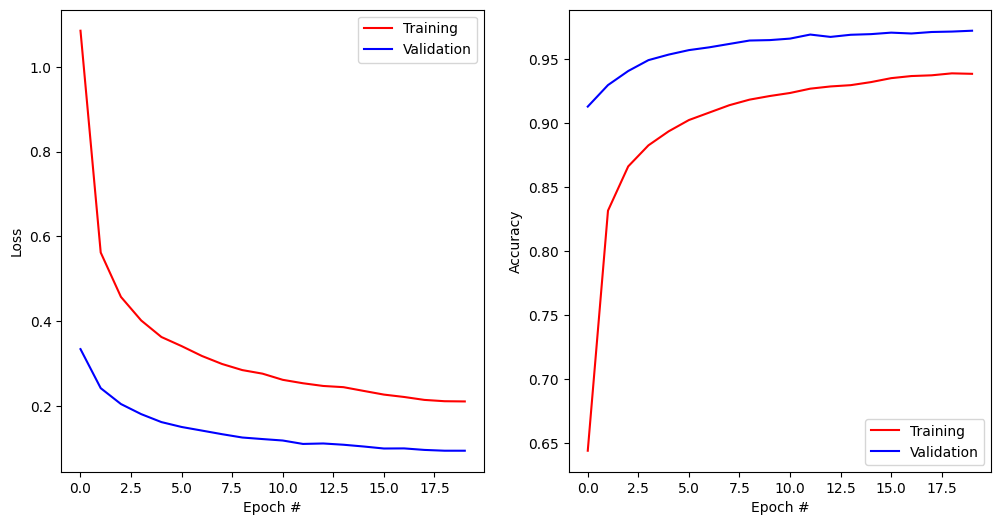

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Initialize the ANN-to-SNN converter

We first create an instance of the ANN-to-SNN conversion object. The function receives the *input_encoding* parameter, which is the type of input encoding we want to use. 

By default, there are *intrinsically bursting* (`IB`), *phase shift oscillation* (`PSO`) and *Poisson* (`poisson`) available.

In [3]:
from ANNarchy.extensions.ann_to_snn_conversion import ANNtoSNNConverter

snn_converter = ANNtoSNNConverter(
    input_encoding='IB', 
    hidden_neuron='IaF',
    read_out='spike_count',
)

ANNarchy 4.8 (4.8.0) on darwin (posix).


After that, we provide the TensorFlow model stored as a `.keras` file to the conversion tool. The print-out of the network structure of the imported network is suppressed when `show_info=False` is provided to `load_keras_model`.

In [4]:
net = snn_converter.load_keras_model("runs/mlp.keras", show_info=True)

* Input layer: input_layer, (784,)
* InputLayer skipped.
* Dense layer: dense, 128 
    weights: (128, 784)
    mean -0.004058694001287222, std 0.0526837483048439
    min -0.35632097721099854, max 0.20212885737419128
* Dropout skipped.
* Dense layer: dense_1, 128 
    weights: (128, 128)
    mean 0.00493684271350503, std 0.10135389119386673
    min -0.28956857323646545, max 0.3801863491535187
* Dropout skipped.
* Dense layer: dense_2, 10 
    weights: (10, 128)
    mean -0.0022533752489835024, std 0.21513012051582336
    min -0.5431588292121887, max 0.5338708162307739



When the network has been built successfully, we can perform a test using all MNIST training samples. Using `duration_per_sample`, the duration simulated for each image can be specified. Here, 200 ms seem to be enough.

In [5]:
predictions_snn = snn_converter.predict(X_test, duration_per_sample=200)

100%|██████████| 10000/10000 [00:53<00:00, 185.25it/s]


Using the recorded predictions, we can now compute the accuracy using scikit-learn for all presented samples.

In [10]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(t_test, predictions_snn))
print("Test accuracy of the SNN:", accuracy_score(t_test, predictions_snn))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.94      0.96       982
           5       0.96      0.96      0.96       892
           6       0.97      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.96      0.95       974
           9       0.94      0.95      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Test accuracy of the SNN: 0.9631


For comparison, here is the performance of the original ANN in keras:

In [11]:
print(classification_report(t_test, predictions_keras.argmax(axis=1)))
print("Test accuracy of the ANN:", accuracy_score(t_test, predictions_keras.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.97      0.96      0.97      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.96      0.96       892
           6       0.97      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Test accuracy of the ANN: 0.9666
